# Clutter Simulation Based Focusing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")
import sys
import marsis

## Read in data and sim

In [2]:
# Data
edr = marsis.EDR("/home/mchristo/proj/orbitRadar/mar-proc/testData/e_08700_ss3_trk_cmp_m.lbl")

# Sim
sim = np.fromfile("/home/mchristo/proj/simc/out/marsis/e_08700_ss3_trk_cmp_m_g_combined.img", dtype=np.float32).reshape(512, 937)

## Calculate time shift to remove rx trigger delay

In [5]:
# Calculate trigger time to align to ellipsoid
c = 299792458
dt = 1.0/1.4e6

# RX window shift
tshiftF1 = (
    edr.anc["RX_TRIG_SA_PROGR"][:, 0] * (1 / 2.8e6)
    - edr.geo["SPACECRAFT_ALTITUDE"] * 2e3 / c
    + 256 * dt
)
tshiftF2 = (
    (edr.anc["RX_TRIG_SA_PROGR"][:, 1]) * (1 / 2.8e6)
    - edr.geo["SPACECRAFT_ALTITUDE"] * 2e3 / c
    + 256 * dt
    - 450e-6  # Delay from xmit F1 to xmit F2
)

## Pulse Compression Without Ionospheric Compensation

In [6]:
# Helper function
def arangeT(start, stop, fs):
    # Function to generate set of
    # Args are start time, stop time, sampling frequency
    # Generates times within the closed interval [start, stop] at 1/fs spacing
    # Double precision floating point

    tTot = stop-start
    nsamp = int(tTot*fs)
    seq = np.arange(nsamp, dtype=np.double)
    seq = seq/fs + start

    return seq

def pc(DATA, ttrig):
    # Reference chirp
    fs = 1.4e6
    tlen = 250e-6
    f0 = -0.5e6
    m = 4.0e9
    t = arangeT(0, tlen, fs)  # time vector
    phi = np.pi*(2*f0*t + m*(t**2))  # phase
    chirp = -1*np.sin(phi) + 1j*np.cos(phi)  # chirp
    
    # Zero pad data
    data = np.fft.ifft(DATA, axis=0)
    data = np.concatenate((data, np.zeros((len(chirp), data.shape[1]))), axis=0)
    
    # Zero pad chirp
    chirp = np.append(chirp, np.zeros(data.shape[0]-len(chirp)))
    
    # Shift data and chirp to baseband
    t = np.arange(len(chirp))*1.0/fs
    bb = np.exp(2*np.pi*1j*-.7e6*t)
    data = data*bb[:, np.newaxis]
    
    # FFT
    DATA = np.fft.fft(data, axis=0)
    CHIRP = np.fft.fft(chirp)

    # Pulse compress
    w = np.fft.fftfreq(len(chirp), d=1.0/fs)*2*np.pi # Angular frequency
    pc = np.zeros_like(DATA)
    for i in range(pc.shape[1]):
        pc[:,i] = np.fft.ifft(DATA[:,i] * np.conj(CHIRP) * np.exp(-1j*w*ttrig[i]))
        
    return pc

## Make a pulse Compressed Product without ionospheric compensation

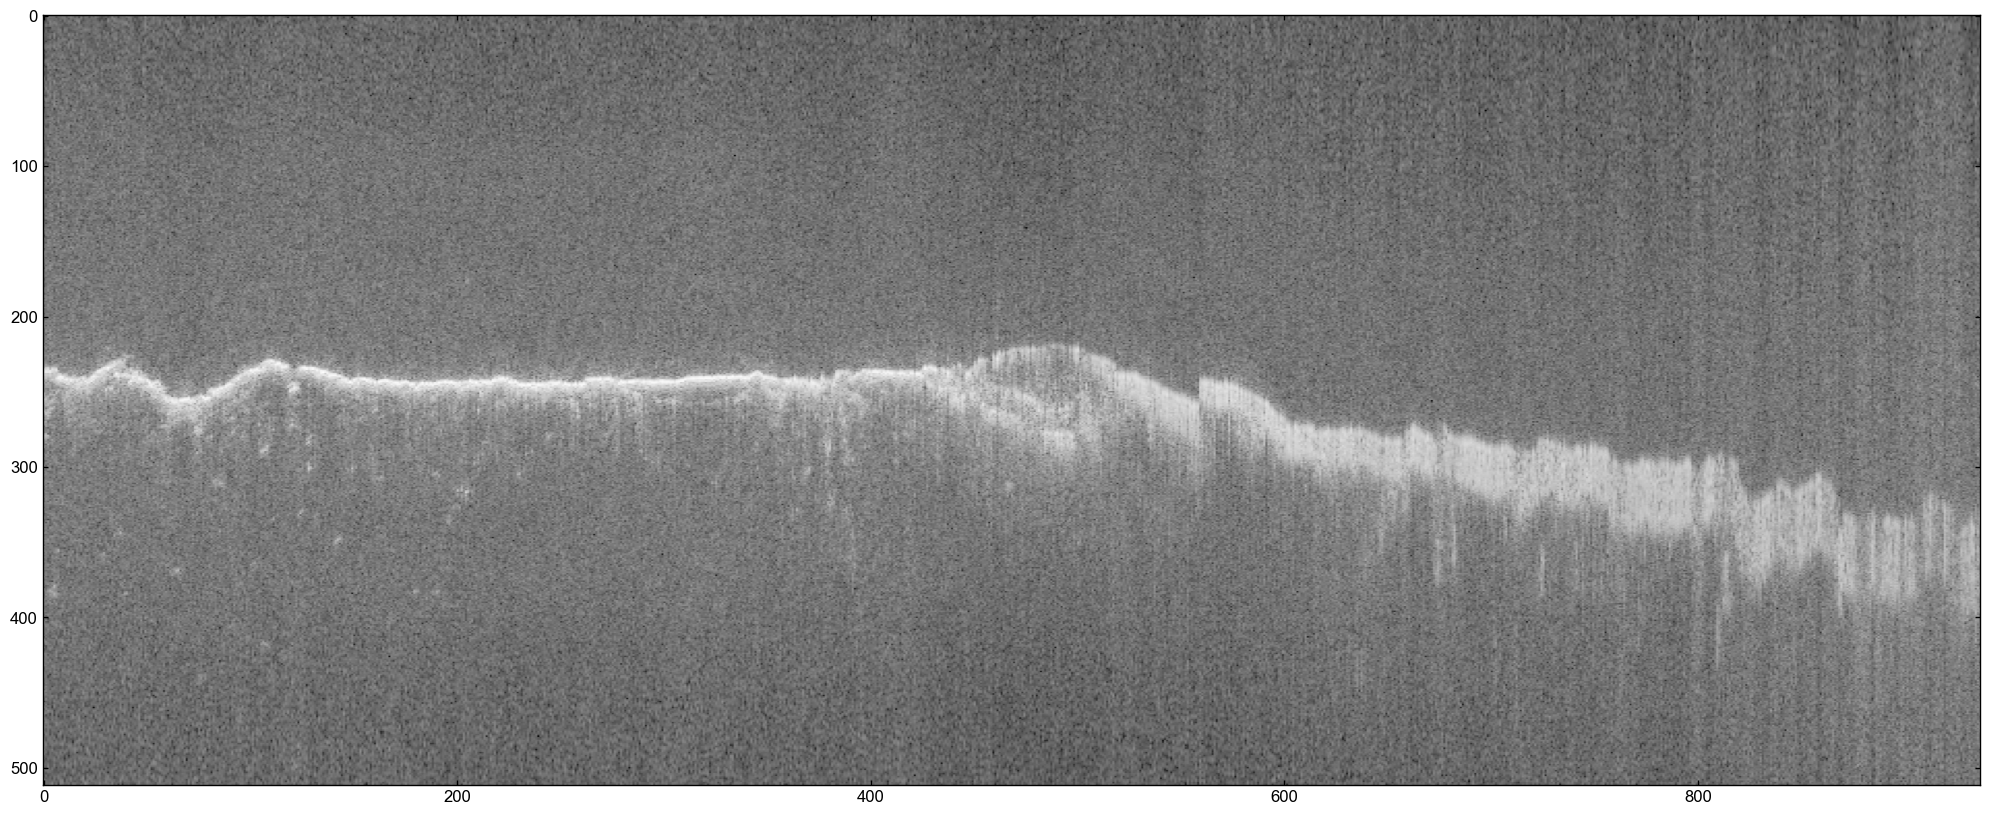

In [8]:
hipc_M1 = pc(edr.data["MINUS1_F1"], tshiftF1)
hipc_Z = pc(edr.data["ZERO_F1"], tshiftF1)
hipc_P1 = pc(edr.data["PLUS1_F1"], tshiftF1)

hipc = (np.abs(hipc_M1) + np.abs(hipc_Z) + np.abs(hipc_P1))[:512,:]

for i in range(hipc.shape[1]):
    hipc[:,i] = hipc[:,i]/np.mean(hipc[:,i])

plt.figure(figsize=(25,10))
plt.imshow(10*np.log(np.abs(hipc)), aspect="auto", cmap="Greys_r")
plt.grid(False)
plt.show()

## Linear and quadratic ionospheric corrction - grid search only

In [ ]:
def ionoGrid(data, sim):
    